In [54]:
import pandas as pd
import glob
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pickle

from tqdm import tqdm

Load the indices and the annotations.

In [20]:
with open('data/indices.json', 'r') as file:
    indices = json.load(file)

train_indices = indices['train']

with open('data/mixed_annotations.json', 'r') as file:
    annotations = json.load(file)

Get the images as a dataframe

In [21]:
annotations = pd.DataFrame.from_dict(annotations['images'])
annotations

,id,width,height,file_name
0,1617,640,480,data/mju/JPEGImages/2019-09-19_16_19_32-29_col...
1,1618,640,480,data/mju/JPEGImages/2019-09-19_16_19_44-93_col...
2,1620,640,480,data/mju/JPEGImages/2019-09-19_16_19_55-63_col...
3,1622,640,480,data/mju/JPEGImages/2019-09-19_16_20_06-93_col...
4,1623,640,480,data/mju/JPEGImages/2019-09-19_16_20_11-29_col...
...,...,...,...,...
3970,5107,1824,4000,data/taco/batch_9/000095.jpg
3971,5108,1824,4000,data/taco/batch_9/000096.jpg
3972,5109,4000,1824,data/taco/batch_9/000097.jpg
3973,5110,1824,4000,data/taco/batch_9/000098.jpg


Slice the dataframe by selecting the images used for train the detector

In [22]:
annotations = annotations.loc[annotations['id'].isin(train_indices), :]
annotations

,id,width,height,file_name
0,1617,640,480,data/mju/JPEGImages/2019-09-19_16_19_32-29_col...
1,1618,640,480,data/mju/JPEGImages/2019-09-19_16_19_44-93_col...
8,1628,640,480,data/mju/JPEGImages/2019-09-19_16_20_44-83_col...
10,1631,640,480,data/mju/JPEGImages/2019-09-19_16_20_59-69_col...
11,1633,640,480,data/mju/JPEGImages/2019-09-19_16_21_12-04_col...
...,...,...,...,...
3969,5106,4000,1824,data/taco/batch_9/000094.jpg
3970,5107,1824,4000,data/taco/batch_9/000095.jpg
3972,5109,4000,1824,data/taco/batch_9/000097.jpg
3973,5110,1824,4000,data/taco/batch_9/000098.jpg


Now, apply the technique used [here](https://towardsdatascience.com/detecting-semantic-drift-within-image-data-6a59a0e768c6). Therefore,
we must open each image individually and get the saturation, brightness and hue, thus, we can obtain more information and probability distributions.

To get the saturation we use the following:
```
img = cv2.imread(img_path)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
saturation = img_hsv[:, :, 1].mean()
hue = img_hsv[:, :, 0].mean()
brightness = img_hsv[:, :, 2].mean()
```

The question is: Should we get an histogram or probability distribution for each image, or get an unique value.

In [10]:
img = cv2.imread('data/taco/batch_9/000094.jpg')
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
saturation = img_hsv[:, :, 1]
hue = img_hsv[:, :, 0]
brightness = img_hsv[:, :, 2]

In [14]:
hist, bins = np.histogram(saturation, bins=np.arange(0, 255, 10), density=True)

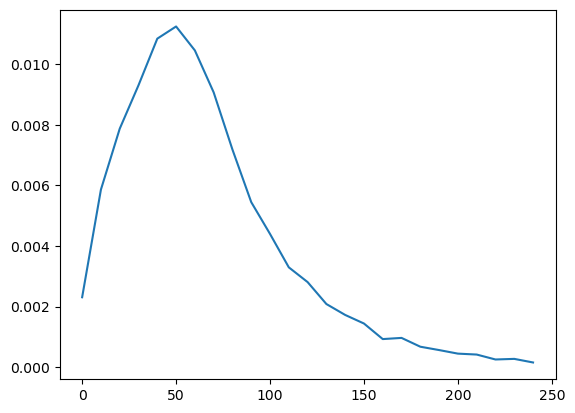

In [18]:
plt.plot(bins[:-1], hist)
plt.show()

Let's check if there is some difference between datasets

In [39]:
taco_hue, background_hue, mju_hue = [], [], []
taco_sat, background_sat, mju_sat = [], [], []
taco_br, background_br, mju_br = [], [], []

for image in tqdm(annotations['file_name'].tolist()):
    img = cv2.imread(image)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    saturation = img_hsv[:, :, 1]
    hue = img_hsv[:, :, 0]
    brightness = img_hsv[:, :, 2]

    saturation_pdf, _ = np.histogram(saturation, bins=np.arange(0, 255, 10), density=True)
    hue_pdf, _ = np.histogram(hue, bins=np.arange(0, 255, 10), density=True)
    brightness_pdf, _ = np.histogram(brightness, bins=np.arange(0, 255, 10), density=True)

    if 'taco' in image:
        taco_sat.append(saturation_pdf)
        taco_br.append(brightness_pdf)
        taco_hue.append(hue_pdf)
    elif 'mju' in image:
        mju_sat.append(saturation_pdf)
        mju_br.append(brightness_pdf)
        mju_hue.append(hue_pdf)
    else:
        background_sat.append(saturation_pdf)
        background_br.apped(brightness_pdf)
        background_hue.append(hue_pdf)


100%|██████████| 3173/3173 [18:43<00:00,  2.82it/s]


Now we are going to check if there are differences in the mean probability density functions
between datasets.

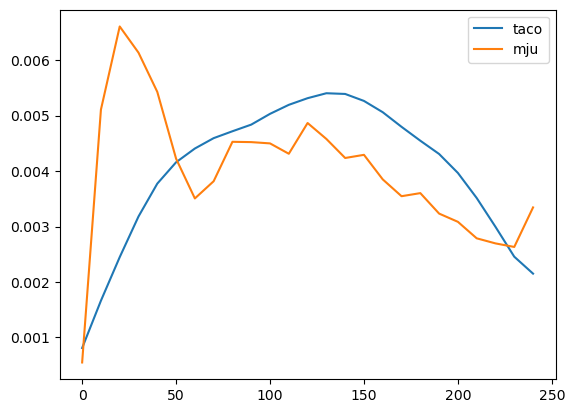

In [40]:
taco_br_mean = np.mean(taco_br, axis=0)
mju_br_mean = np.mean(mju_br, axis=0)

plt.plot(bins[:-1], taco_br_mean, label='taco')
plt.plot(bins[:-1], mju_br_mean, label='mju')
plt.legend()
plt.show()

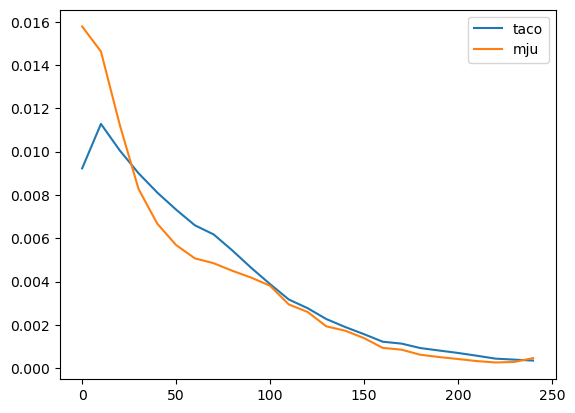

In [41]:
taco_sat_mean = np.mean(taco_sat, axis=0)
mju_sat_mean = np.mean(mju_sat, axis=0)

plt.plot(bins[:-1], taco_sat_mean, label='taco')
plt.plot(bins[:-1], mju_sat_mean, label='mju')
plt.legend()
plt.show()

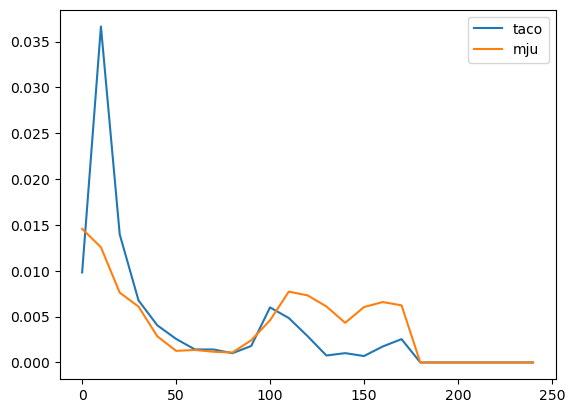

In [44]:
taco_hue_mean = np.mean(taco_hue, axis=0)
mju_hue_mean = np.mean(mju_hue, axis=0)

plt.plot(bins[:-1], taco_hue_mean, label='taco')
plt.plot(bins[:-1], mju_hue_mean, label='mju')
plt.legend()
plt.show()

As shown in the charts above, there are some differences between the density functions
between datasets. Given that we have trained the models with both datasets, we will
compute the mean density function between the two datasets. Thus, we will serialize
that density functions to detect data drift in production.

In [50]:
br_mean = taco_br_mean + mju_br_mean
sat_mean = taco_sat_mean + mju_sat_mean
hue_mean = taco_hue_mean + mju_hue_mean

In [55]:
data = {
    'brightness': br_mean,
    'saturation': sat_mean,
    'hue': hue_mean
}

with open('training_data_dist.pkl', 'wb') as file:
    pickle.dump(data, file)